In [87]:
import bitvec

In [88]:
import bitvec
from bitvec import Binary

from bitvec.alias import u8, i8
import bitvec.arithm as arithm

In [89]:
u8("0000 0001")

00000001

In [90]:
bitvec.Binary("11111000", lenght=8)-1

11110111

In [91]:
pattern = """"{num}": [
        "lda 0",
        "addi 4",
        "{instruction}",
    ],"""

for i in range(9, 15):
    print(pattern.format(num=i, instruction=f"addi {i-8+5}"))


"9": [
        "lda 0",
        "addi 4",
        "addi 6",
    ],
"10": [
        "lda 0",
        "addi 4",
        "addi 7",
    ],
"11": [
        "lda 0",
        "addi 4",
        "addi 8",
    ],
"12": [
        "lda 0",
        "addi 4",
        "addi 9",
    ],
"13": [
        "lda 0",
        "addi 4",
        "addi 10",
    ],
"14": [
        "lda 0",
        "addi 4",
        "addi 11",
    ],


In [81]:
import z3

def find_number_shifts(target: int, num_operations: int = 1):
    for i in range(1, 10):
        # Define the bit-width for 8-bit numbers
        BIT_WIDTH = 8

        # Define the initial accumulator (acc) as a Z3 BitVec
        acc = z3.BitVec('acc', BIT_WIDTH)
        
        # Define the array of operations
        num_operations = i  # Maximum number of operations
        operations = z3.Array('operations', z3.IntSort(), z3.IntSort())

        # The result after applying operations
        result = z3.BitVec('result', BIT_WIDTH)
        
        # Solver instance
        s = z3.Solver()

        # Define operation constants
        OP_ADD = 0
        OP_SHIFT = 1
        OP_NEG = 2

        # Define an array to hold intermediate results
        intermediate = [z3.BitVec(f'intermediate_{i}', BIT_WIDTH) for i in range(num_operations + 1)]

        # The first intermediate value is the initial accumulator
        s.add(intermediate[0] == 0)

        # Constraints for each operation
        for i in range(num_operations):
            op = z3.Select(operations, i)  # Get the operation at index i
            imm = z3.BitVec(f'imm_{i}', BIT_WIDTH)  # Immediate value for addition
            s.add(imm >= -8, imm <= 7)  # Immediate value constraint

            # Apply the operation based on its type
            cond_add = z3.And(op == OP_ADD, intermediate[i + 1] == (intermediate[i] + imm) & 0xFF)
            cond_shift = z3.And(op == OP_SHIFT, intermediate[i + 1] == (intermediate[i] << 1) & 0xFF)
            cond_neg = z3.And(op == OP_NEG, intermediate[i + 1] == ~intermediate[i] & 0xFF)

            # Ensure exactly one operation applies
            s.add(z3.Or(cond_add, cond_shift, cond_neg))

        # The last intermediate value must match the target
        s.add(intermediate[-1] == target)

        # Solve the constraints
        if s.check() == z3.sat:
            model = s.model()

            buffer = ['lda 0']
            print(f"// Target: {target}, Operations: {num_operations}")
            for i in range(num_operations):
                op = model.eval(z3.Select(operations, i)).as_long()
                if op == OP_ADD:
                    imm = model.eval(z3.BitVec(f'imm_{i}', BIT_WIDTH)).as_long()
                    if imm >= 8:
                        print(f"addi {imm-256}")
                        buffer.append(f"addi {imm-256}")
                    else:
                        print(f"addi {imm}")
                        buffer.append(f"addi {imm}")
                elif op == OP_SHIFT:
                    print("add acc")
                    buffer.append("add acc")
                elif op == OP_NEG:
                    print("nand acc")
                    buffer.append("nand acc")
            return buffer
    else:
        print(f"Target {target} not reachable with {num_operations} operations")


solutions = dict()
# Example usage
for target in range(256):
    solution = find_number_shifts(target, i)
    if solution:
        solutions[str(target)] = solution


// Target: 0, Operations: 1
addi 0
// Target: 1, Operations: 1
addi 1
// Target: 2, Operations: 1
addi 2
// Target: 3, Operations: 1
addi 3
// Target: 4, Operations: 1
addi 4
// Target: 5, Operations: 1
addi 5
// Target: 6, Operations: 1
addi 6
// Target: 7, Operations: 1
addi 7
// Target: 8, Operations: 2
addi 4
add acc
// Target: 9, Operations: 2
addi 4
addi 5
// Target: 10, Operations: 2
addi 5
add acc
// Target: 11, Operations: 2
addi 6
addi 5
// Target: 12, Operations: 2
addi 6
add acc
// Target: 13, Operations: 2
addi 7
addi 6
// Target: 14, Operations: 2
addi 7
add acc
// Target: 15, Operations: 3
addi -8
add acc
nand acc
// Target: 16, Operations: 3
addi 2
addi 6
add acc
// Target: 17, Operations: 3
addi 4
addi 6
addi 7
// Target: 18, Operations: 3
addi 4
addi 5
add acc
// Target: 19, Operations: 3
addi 6
add acc
addi 7
// Target: 20, Operations: 3
addi 5
add acc
add acc
// Target: 21, Operations: 3
addi 7
add acc
addi 7
// Target: 22, Operations: 3
addi 4
addi 7
add acc
// Tar

In [92]:
print(solutions)

{'0': ['lda 0', 'addi 0'], '1': ['lda 0', 'addi 1'], '2': ['lda 0', 'addi 2'], '3': ['lda 0', 'addi 3'], '4': ['lda 0', 'addi 4'], '5': ['lda 0', 'addi 5'], '6': ['lda 0', 'addi 6'], '7': ['lda 0', 'addi 7'], '8': ['lda 0', 'addi 4', 'add acc'], '9': ['lda 0', 'addi 4', 'addi 5'], '10': ['lda 0', 'addi 5', 'add acc'], '11': ['lda 0', 'addi 6', 'addi 5'], '12': ['lda 0', 'addi 6', 'add acc'], '13': ['lda 0', 'addi 7', 'addi 6'], '14': ['lda 0', 'addi 7', 'add acc'], '15': ['lda 0', 'addi -8', 'add acc', 'nand acc'], '16': ['lda 0', 'addi 2', 'addi 6', 'add acc'], '17': ['lda 0', 'addi 4', 'addi 6', 'addi 7'], '18': ['lda 0', 'addi 4', 'addi 5', 'add acc'], '19': ['lda 0', 'addi 6', 'add acc', 'addi 7'], '20': ['lda 0', 'addi 5', 'add acc', 'add acc'], '21': ['lda 0', 'addi 7', 'add acc', 'addi 7'], '22': ['lda 0', 'addi 4', 'addi 7', 'add acc'], '23': ['lda 0', 'addi -6', 'add acc', 'add acc', 'nand acc'], '24': ['lda 0', 'addi 6', 'add acc', 'add acc'], '25': ['lda 0', 'addi -8', 'addi

In [100]:
import json

json.dump(solutions, open("solutions.json", "w"), indent=4)

Text(0.5, 1.0, 'Number of operations to reach target value')

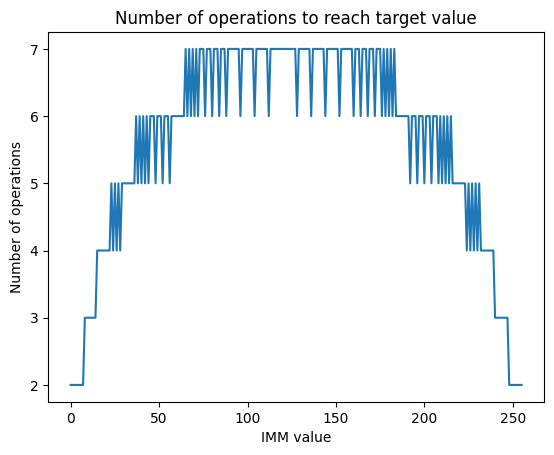

In [98]:
import matplotlib.pyplot as plt

plt.plot([len(solutions[str(i)]) for i in range(256)])
plt.ylabel('Number of operations')
plt.xlabel('IMM value')
plt.title('Number of operations to reach target value')

In [104]:
import z3

def find_number_shifts(target: int, num_operations: int = 1):
    for i in range(1, 10):
        # Define the bit-width for 8-bit numbers
        BIT_WIDTH = 8

        # Define the initial accumulator (acc) as a Z3 BitVec
        acc = z3.BitVec('acc', BIT_WIDTH)
        
        # Define the array of operations
        num_operations = i  # Maximum number of operations
        operations = z3.Array('operations', z3.IntSort(), z3.IntSort())

        # The result after applying operations
        result = z3.BitVec('result', BIT_WIDTH)
        
        # Solver instance
        s = z3.Solver()

        # Define operation constants
        OP_ADD = 0
        OP_SHIFT = 1
        OP_NEG = 2
        OP_SHIFT4 = 3

        # Define an array to hold intermediate results
        intermediate = [z3.BitVec(f'intermediate_{i}', BIT_WIDTH) for i in range(num_operations + 1)]

        # The first intermediate value is the initial accumulator
        s.add(intermediate[0] == 0)

        # Constraints for each operation
        for i in range(num_operations):
            op = z3.Select(operations, i)  # Get the operation at index i
            imm = z3.BitVec(f'imm_{i}', BIT_WIDTH)  # Immediate value for addition
            s.add(imm >= -8, imm <= 7)  # Immediate value constraint

            # Apply the operation based on its type
            cond_add = z3.And(op == OP_ADD, intermediate[i + 1] == (intermediate[i] + imm) & 0xFF)
            cond_shift = z3.And(op == OP_SHIFT, intermediate[i + 1] == (intermediate[i] << 1) & 0xFF)
            cond_neg = z3.And(op == OP_NEG, intermediate[i + 1] == ~intermediate[i] & 0xFF)
            cond_shift4 = z3.And(op == OP_SHIFT4, intermediate[i + 1] == (intermediate[i] << 4) & 0xFF)

            # Ensure exactly one operation applies
            s.add(z3.Or(cond_add, cond_shift, cond_neg, cond_shift4))

        # The last intermediate value must match the target
        s.add(intermediate[-1] == target)

        # Solve the constraints
        if s.check() == z3.sat:
            model = s.model()

            buffer = ['lda 0']
            print(f"// Target: {target}, Operations: {num_operations}")
            for i in range(num_operations):
                op = model.eval(z3.Select(operations, i)).as_long()
                if op == OP_ADD:
                    imm = model.eval(z3.BitVec(f'imm_{i}', BIT_WIDTH)).as_long()
                    if imm >= 8:
                        print(f"addi {imm-256}")
                        buffer.append(f"addi {imm-256}")
                    else:
                        print(f"addi {imm}")
                        buffer.append(f"addi {imm}")
                elif op == OP_SHIFT:
                    print("add acc")
                    buffer.append("add acc")
                elif op == OP_NEG:
                    print("nand acc")
                    buffer.append("nand acc")
                elif op == OP_SHIFT4:
                    print("lsh4 acc")
                    buffer.append("lsh4 acc")
            return buffer
    else:
        print(f"Target {target} not reachable with {num_operations} operations")


solutions = dict()
# Example usage
for target in range(256):
    solution = find_number_shifts(target, i)
    if solution:
        solutions[str(target)] = solution


// Target: 0, Operations: 1
add acc
// Target: 1, Operations: 1
addi 1
// Target: 2, Operations: 1
addi 2
// Target: 3, Operations: 1
addi 3
// Target: 4, Operations: 1
addi 4
// Target: 5, Operations: 1
addi 5
// Target: 6, Operations: 1
addi 6
// Target: 7, Operations: 1
addi 7
// Target: 8, Operations: 2
addi 4
add acc
// Target: 9, Operations: 2
addi 5
addi 4
// Target: 10, Operations: 2
addi 5
add acc
// Target: 11, Operations: 2
addi 7
addi 4
// Target: 12, Operations: 2
addi 6
add acc
// Target: 13, Operations: 2
addi 6
addi 7
// Target: 14, Operations: 2
addi 7
add acc
// Target: 15, Operations: 3
addi -8
add acc
nand acc
// Target: 16, Operations: 2
addi 1
lsh4 acc
// Target: 17, Operations: 3
addi 6
add acc
addi 5
// Target: 18, Operations: 3
addi 4
addi 5
add acc
// Target: 19, Operations: 3
addi 6
add acc
addi 7
// Target: 20, Operations: 3
addi 4
addi 6
add acc
// Target: 21, Operations: 3
addi 7
add acc
addi 7
// Target: 22, Operations: 3
addi 4
addi 7
add acc
// Target: 

In [105]:
json.dump(solutions, open("solutions-lsh4.json", "w"), indent=4)

In [94]:
for k, v in solutions.items():
    print(f'{k}: {len(v)},')

0: 2,
1: 2,
2: 2,
3: 2,
4: 2,
5: 2,
6: 2,
7: 2,
8: 3,
9: 3,
10: 3,
11: 3,
12: 3,
13: 3,
14: 3,
15: 4,
16: 4,
17: 4,
18: 4,
19: 4,
20: 4,
21: 4,
22: 4,
23: 5,
24: 4,
25: 5,
26: 4,
27: 5,
28: 4,
29: 5,
30: 5,
31: 5,
32: 5,
33: 5,
34: 5,
35: 5,
36: 5,
37: 6,
38: 5,
39: 6,
40: 5,
41: 6,
42: 5,
43: 6,
44: 5,
45: 6,
46: 6,
47: 6,
48: 5,
49: 6,
50: 6,
51: 6,
52: 5,
53: 6,
54: 6,
55: 6,
56: 5,
57: 6,
58: 6,
59: 6,
60: 6,
61: 6,
62: 6,
63: 6,
64: 6,
65: 7,
66: 6,
67: 7,
68: 6,
69: 7,
70: 6,
71: 7,
72: 6,
73: 7,
74: 7,
75: 7,
76: 6,
77: 7,
78: 7,
79: 7,
80: 6,
81: 7,
82: 7,
83: 7,
84: 6,
85: 7,
86: 7,
87: 7,
88: 6,
89: 7,
90: 7,
91: 7,
92: 7,
93: 7,
94: 7,
95: 7,
96: 6,
97: 7,
98: 7,
99: 7,
100: 7,
101: 7,
102: 7,
103: 7,
104: 6,
105: 7,
106: 7,
107: 7,
108: 7,
109: 7,
110: 7,
111: 7,
112: 6,
113: 7,
114: 7,
115: 7,
116: 7,
117: 7,
118: 7,
119: 7,
120: 7,
121: 7,
122: 7,
123: 7,
124: 7,
125: 7,
126: 7,
127: 7,
128: 6,
129: 7,
130: 7,
131: 7,
132: 7,
133: 7,
134: 7,
135: 7,
136: 6,
137: 7,
138: 7

In [95]:


def x(i):
    o = oct(i).removeprefix("0o")

    o = o.zfill(3)

    print(o)

    return """[
        "lda 0",
        "addi {i}",
    ]""".format(i=o)


for i in range(0, 255):
    x(i)



000
001
002
003
004
005
006
007
010
011
012
013
014
015
016
017
020
021
022
023
024
025
026
027
030
031
032
033
034
035
036
037
040
041
042
043
044
045
046
047
050
051
052
053
054
055
056
057
060
061
062
063
064
065
066
067
070
071
072
073
074
075
076
077
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
120
121
122
123
124
125
126
127
130
131
132
133
134
135
136
137
140
141
142
143
144
145
146
147
150
151
152
153
154
155
156
157
160
161
162
163
164
165
166
167
170
171
172
173
174
175
176
177
200
201
202
203
204
205
206
207
210
211
212
213
214
215
216
217
220
221
222
223
224
225
226
227
230
231
232
233
234
235
236
237
240
241
242
243
244
245
246
247
250
251
252
253
254
255
256
257
260
261
262
263
264
265
266
267
270
271
272
273
274
275
276
277
300
301
302
303
304
305
306
307
310
311
312
313
314
315
316
317
320
321
322
323
324
325
326
327
330
331
332
333
334
335
336
337
340
341
342
343
344
345
346
347
350
351
352
353
354
355
356
357
360
361
362
363
364
365
366
367
370
371
